In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from fme_diags.time_mean import plot_time_mean

_ = xr.set_options(keep_attrs=True)

In [2]:
RUN_KEY = "42yrs-batch_size8-max_epochs50-lr3e-4-run4"
FIG_PREFIX = "era5"
OUTDIR = f"figs/{RUN_KEY}"
os.makedirs(OUTDIR, exist_ok=True)

VARNAME = "PRECT_diff"
UNITS = "mm/day"

In [3]:
DATADIR = f"../data/{RUN_KEY}"
assert os.path.isdir(DATADIR), f"{DATADIR} doesn't exist."

TARGET_NC = os.path.join(DATADIR, "ERA5-PRECT-ANN-global_diff-target.nc")
PREDICTION_NC = os.path.join(DATADIR, "ERA5-PRECT-ANN-global_diff-prediction.nc")

assert os.path.isfile(TARGET_NC), f"{TARGET_NC} doesn't exist; please add it first."
assert os.path.isfile(PREDICTION_NC), f"{PREDICTION_NC} doesn't exist; please add it first."

In [4]:
da = xr.concat(
    [xr.open_dataset(TARGET_NC)[VARNAME], 
     xr.open_dataset(PREDICTION_NC)[VARNAME]],
    dim="source",
).assign_coords({"source": ["target", "prediction"]}).assign_attrs(units=UNITS)

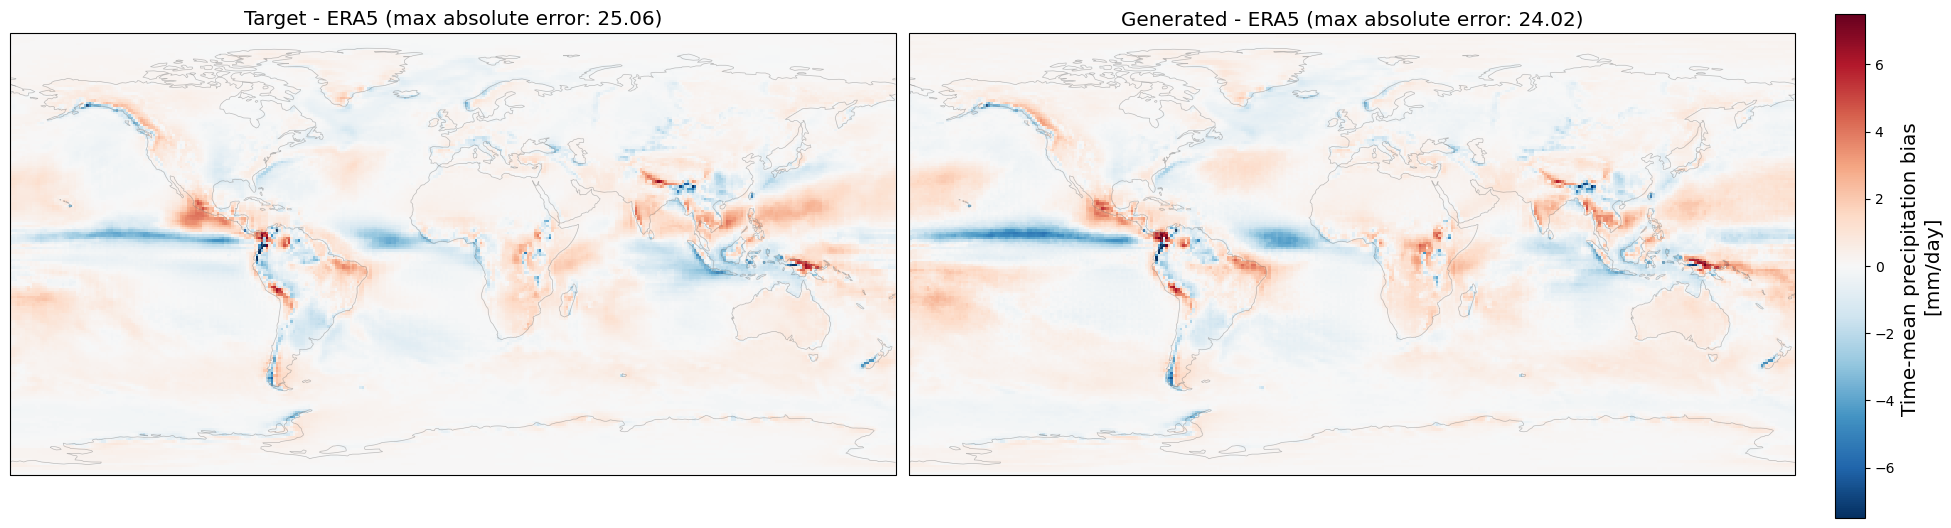

In [5]:
vmax_abs = 7.5 # np.quantile(np.abs(da), 0.99999)

fig, axs = plot_time_mean(
    da.sel(source="prediction"), 
    da.sel(source="target"),
    var_name="precipitation",
    metric_name="bias",
    norm=TwoSlopeNorm(0.0, -vmax_abs, vmax_abs),
)
axs[0].set_title(
    f"Target - ERA5 (max absolute error: {np.abs(da.sel(source='target')).max().item():.2f})",
    fontsize="x-large"
)
axs[1].set_title(
    f"Generated - ERA5 (max absolute error: {np.abs(da.sel(source='prediction')).max().item():.2f})",
    fontsize="x-large"
)

fig.show()

In [6]:
fig.savefig(os.path.join(OUTDIR, f"{FIG_PREFIX}_fig1.png"), bbox_inches="tight")